# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Иванов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = \dots $$

## Имплементация (5 баллов)

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, random_state = 0):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.random_state = random_state
        
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x)) 
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        np.random.seed(self.random_state)
        X = np.c_[np.ones(X.shape[0]), X]
        self.weights = np.empty(X.shape[1])
        self.loss_list = []
        for epoch in range(self.max_epoch):
            lr = self.alpha/(epoch + 1)
            shuffled_index = np.random.permutation(X.shape[0])
            X, y = X[shuffled_index], y[shuffled_index]
            batch_size = np.sqrt(X.shape[0]).astype(int)
            batch_starts = np.arange(0, X.shape[0] , batch_size)
            
            for index in batch_starts:
                
                X_batch, y_batch = X[index:index + batch_size], y[index:index + batch_size]
                
                y_hat = self.predict_proba(X_batch)
                gradient = X_batch.T.dot(y_hat - y_batch)/X_batch.shape[0]
                #no regularization for bias:
                gradient += (2.0 / self.C) * np.append(np.array([0]),self.weights[1:])/X_batch.shape[0]
                
                
                self.weights -= gradient * lr
                
                
            y_epoch = self.predict_proba(X)   
            loss = np.mean(-y * np.log(y_epoch) - (1 - y) * np.log(1 - y_epoch))
            self.loss_list.append(loss)
            
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X = np.c_[np.ones(X.shape[0]), X]
        y_hat = (np.dot(X, self.weights) > 0).astype(int)
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        y_hat_proba = self.sigmoid(np.dot(X, self.weights))
        return y_hat_proba
        
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

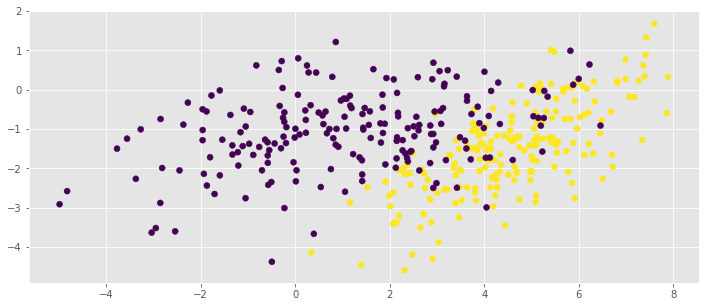

In [227]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [228]:
model = MySGDClassifier(max_epoch=100, alpha=0.5, C=10)
model.fit(X, y)

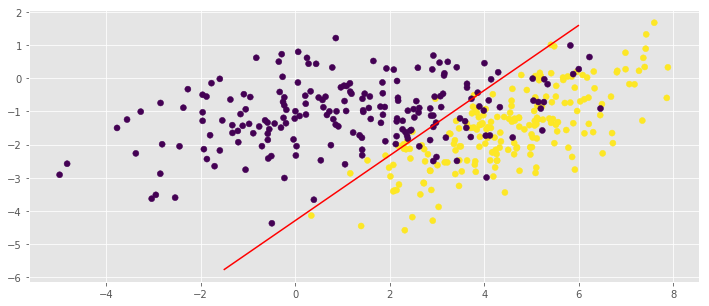

In [229]:
x_axis = np.arange(-1.5, 6,.01)
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)
y_line = (-model.weights[0] - (model.weights[1] * x_axis)) / model.weights[2]
plt.plot(x_axis, y_line, "r-")

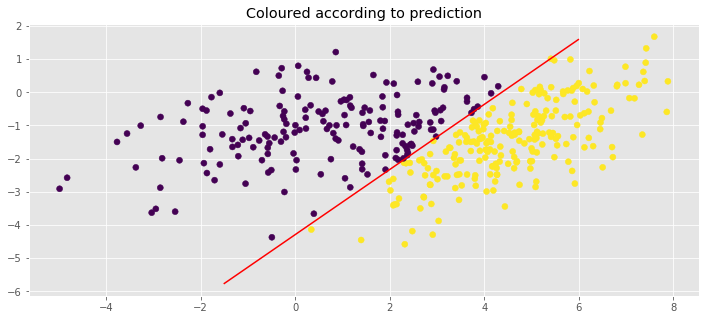

In [230]:
x_axis = np.arange(-1.5, 6,.01)
plt.scatter(X[:, 0], X[:, 1], marker="o", c=model.predict(X))
y_line = (-model.weights[0] - (model.weights[1] * x_axis)) / model.weights[2]
plt.plot(x_axis, y_line, "r-")
plt.title("Coloured according to prediction")

In [212]:
print 'Веса: ', model.weights

Веса:  [-3.03393159  0.7604054  -0.68494022]


## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [213]:
from sklearn.datasets import make_classification

In [214]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

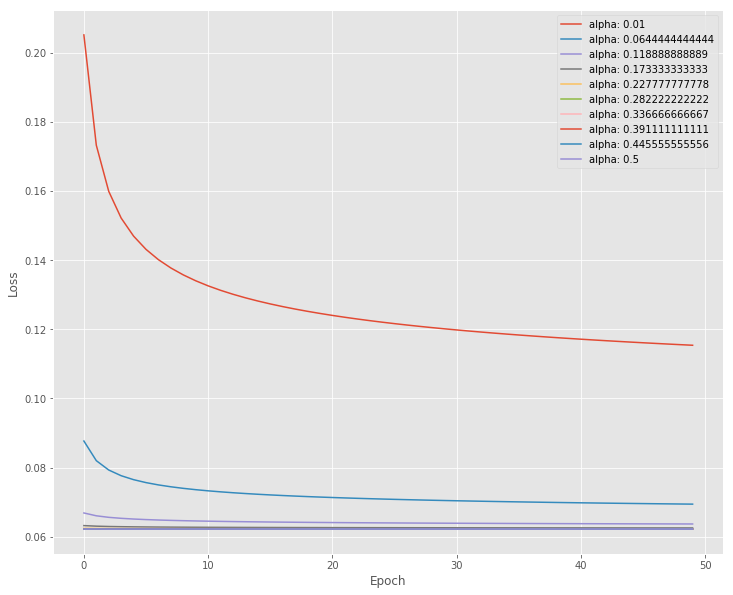

In [215]:
plt.rcParams['figure.figsize'] = (12,10)
alpha_values = np.linspace(0.01, 0.5, 10)
for alpha in alpha_values:
    model = MySGDClassifier(alpha=alpha, C=10, max_epoch=50)
    model.fit(X, y)
    plt.plot(model.loss_list, label='alpha: {}'.format(alpha))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

KeyboardInterrupt: 

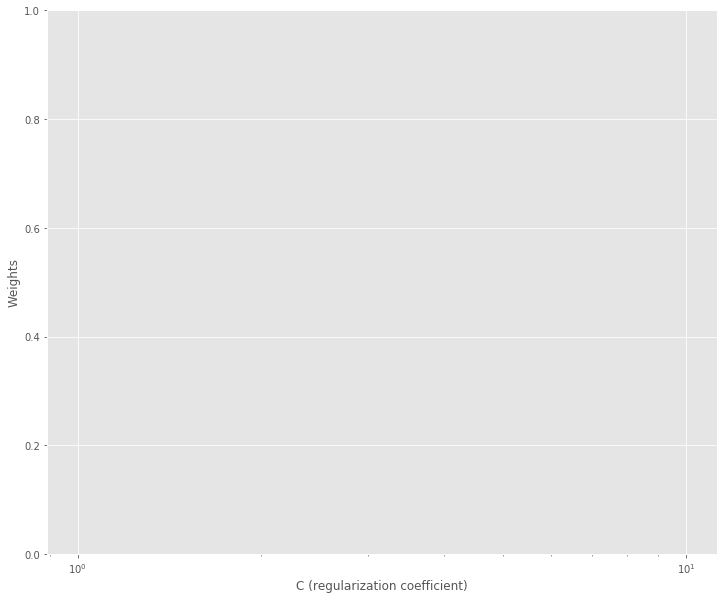

In [216]:
plt.xscale('log')
plt.ylabel('Weights')
plt.xlabel('C (regularization coefficient)')


C_number = 10
weights_number = X.shape[1] + 1
weights = np.empty((C_number, weights_number))

C_values = np.logspace(3, -3, C_number)

for i in range(C_number):
    model = MySGDClassifier(alpha=0.3, C=C_values[i], max_epoch=100)
    model.fit(X, y)
    weights[i] = model.weights
    
for i in range(weights_number):
    plt.plot(C_values, weights[:, i], label='w' + str(i))

plt.legend()

(Здесь коэффициент при добавочном члене - это 1/C, то есть при большем значении коэффициента меньше влияет регуляризация и могут получаться большие веса, как и показано на графике).

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [5]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [6]:
df_data.shape

(2000000, 45)

In [7]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [8]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [9]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50479949999999996

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [14]:
print 'Уникальных карт героя у игрока: ', df_data['player_hero_card_id'].nunique()
print 'Уникальных карт героя у оппонента: ', df_data['opponent_hero_card_id'].nunique()

Уникальных карт героя у игрока:  9
Уникальных карт героя у оппонента:  9


In [19]:
df_data = pd.get_dummies(data=df_data, columns=['player_hero_card_id', 'opponent_hero_card_id'])

In [20]:
df_data.head()

,decision,turn,opponent_armor,opponent_attack,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,opponent_deck_count,...,player_hero_card_id_1235,opponent_hero_card_id_25,opponent_hero_card_id_326,opponent_hero_card_id_390,opponent_hero_card_id_494,opponent_hero_card_id_612,opponent_hero_card_id_754,opponent_hero_card_id_798,opponent_hero_card_id_981,opponent_hero_card_id_1235
gamestate_id,,,,,,,,,,,,,,,,,,,,,
4687346.0,1,14,0,0,5,0,0,10,10,11,...,0,0,0,0,0,0,0,1,0,0
3270826.0,1,7,0,0,22,0,0,6,6,19,...,0,0,0,0,0,0,1,0,0,0
3189487.0,1,5,3,0,29,0,0,4,1,22,...,0,0,0,0,0,1,0,0,0,0
4098946.0,1,8,0,0,26,0,0,7,7,17,...,0,0,0,1,0,0,0,0,0,0
2661127.0,0,13,0,0,30,0,0,10,1,12,...,0,1,0,0,0,0,0,0,0,0


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [ ]:
## Youd Code Here

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [ ]:
## Youd Code Here